# DEJONGHE Hadrien & Esteban NABONNE E4 DSIA
Work for DRL_Tutorial for the course DSIA_4302C - Deep & Reinforcement Learning

Professor : Arben Cela

# Adaptive Noise Cancellation
Doctor, in trying to review the electroencephalogram (EEG) of a distracted graduate student, finds that the signal he would like to see has been contaminated by a 60-Hz noise source. He is examining the patient on-line and wants to view the best signal that can be obtained.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from keras import models
from keras import layers
from keras import optimizers

In [2]:
# Architecture of ADALINE of order 1:

from IPython.display import Image
Image("Adaline_Adaptive_Filter.png")

FileNotFoundError: No such file or directory: 'Adaline_Adaptive_Filter.png'

FileNotFoundError: No such file or directory: 'Adaline_Adaptive_Filter.png'

<IPython.core.display.Image object>

In [ ]:
S= np.loadtxt('Data_EEG.txt',skiprows=1,unpack=True)
S_sqr=np.square(S)
Mean_S_sqr=np.mean(S_sqr)
n=len(S)

# Create the unfiltered signal $t(k)=S(k)+m(k)$
- $S(k)$: is the **pure EEG signal**
- $v(k)$: is the sampled sinusoidal electrical network signal (three times in a period) and considered as the input signal to ADALINE network and its output
- $m(k)$:  is the noisy signal comming from the electrical network.
- $t(k)$: is the unfiltered signal (t(k)=S(k)+m(k))
- $a(k)$: is the estimation of the noisy signal m(k).
- plot the pure signal $S(k)$ and unfiltered signal $T(k)$ in order to evaluate the filtering operated by ADALINE network.

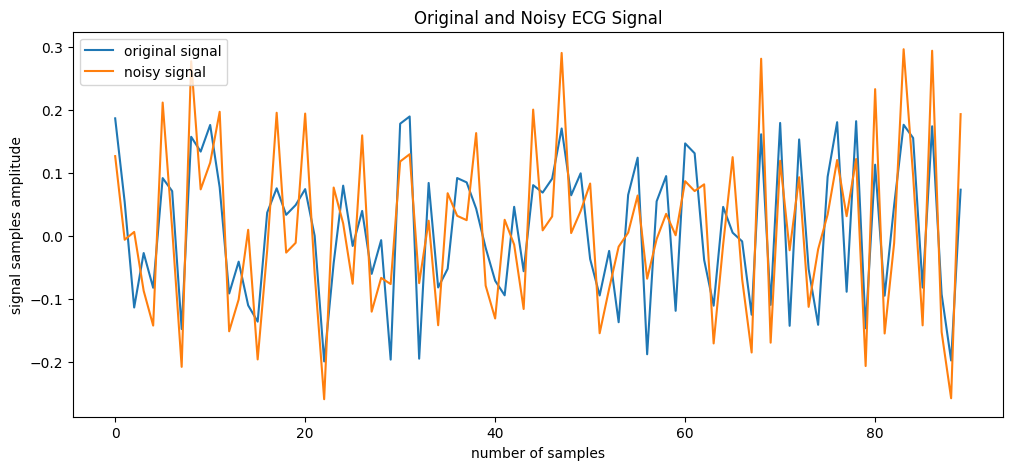

In [ ]:
v=[]
m=[]
for i in range(30):
     v=np.concatenate((v,[1.2*np.sin(2*np.pi*(1/3)), 1.2*np.sin(2*np.pi*(2/3)), 1.2*np.sin(2*np.pi*(3/3))]))
     m=np.concatenate((m,[0.12*np.sin((2*np.pi*(1/3))+np.pi/2), 0.12*np.sin((2*np.pi*(2/3))+np.pi/2), 0.12*np.sin((2*np.pi*(3/3))+np.pi/2)]))

# Contaminated output signal
t=S+m
# Plot of the original and noisy ECG signals
plt.figure(1,figsize=(12,5))
plt.plot(S)
plt.plot(t)
plt.legend(('original signal','noisy signal'),loc='upper left')
plt.title('Original and Noisy ECG Signal')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

In [ ]:
# -------------------------------
# 2. Theoretical Weight Calculation for 2-input ADALINE
# -------------------------------
# v(k)=1.2*sin(2*pi*k/3) and m(k)=0.12*sin(2*pi*k/3 + pi/2)
# The theoretical correlation matrix and cross-correlation vector are:
R_theo = np.array([[0.72, -0.36],
                   [-0.36, 0.72]])
h_theo = np.array([0, -0.0624])
# The theoretical weight vector is:
w_theo = np.dot(inv(R_theo), h_theo)
print("Theoretical weights (2-input ADALINE):", w_theo)

Theoretical weights (2-input ADALINE): [-0.05777778 -0.11555556]


# Filter Order Selection
ADALINE output $a(t)$ may be calculated based on:
- a first order model given in the figure using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$
- a second order model given by  the mathematical expression:  $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$

where the order is the number of retarded inputs signals used as input to neural network.

# First Order Filter Design:  Optimal Solution
- The optimal solution is obtained by minimizing **least mean square** (LMS) between
the unfiltered signal T(k) and the output of the second order filter given
by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. For more details please **see course slide nr.19**.
- $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$
- Let us note: $x=[w_1, b]^T$ and $ z=[v,1]^T \Rightarrow a=x^Tz $ is the ADALINE output
- Solution:  $w=R^{-1}h$ where  $h=E[tz]$ and   $R=E[zz^T]$
- In our calculation we have considered that the biais value $b=0$





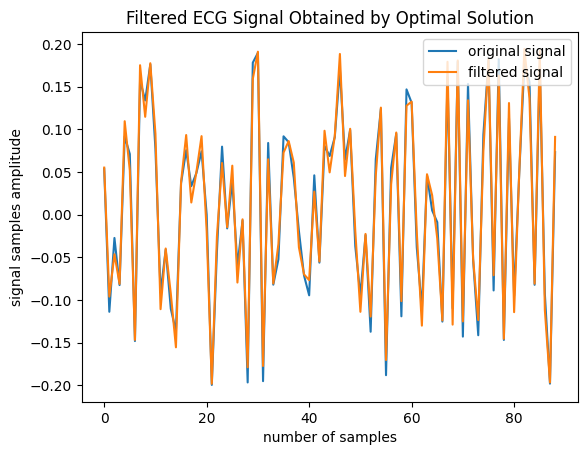

In [ ]:
case="1ordre"
if case=='1ordre': # case of third order filter calculation
    n=len(t)-1
    w=np.array([0 , 0]) # initial values of synaptic weights
    b=0                 # initial values of baised value
    a=np.zeros(len(t)-1); # initial value of ADALINE network output
    V=np.array([v[1:90], v[0:89]]) #input signal
    T=t[1:90] # target signal


 # Minimizing the square of difference between target signal and ADALINE network output
# Optimal solution (see course slide nr. 19)
    Cov_R=np.cov(v[1:90], v[0:89])
    Cov_h=np.dot(V,T.T)/len(t[1:])
    w1=np.dot(inv(Cov_R),Cov_h.T)
    a1=np.dot(w1.T,V) # simulate the ADALINE for optimal solution on input signals
    e1=T-a1 # Initial filtered signal values

    plt.figure(2)
    plt.plot(S[1:90])
    plt.plot(e1)
    plt.legend(('original signal','filtered signal'),loc='upper right')
    plt.title('Filtered ECG Signal Obtained by Optimal Solution')
    plt.xlabel('number of samples')
    plt.ylabel('signal samples amplitude')
    plt.show()
    e=T-a
    J=[]


# First Order Filter Design: ADALINE Design Based on Iterative Solution
- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. **For more details please see course slide nr.23**.
- There is no biaised value **b** considered for ADALINE
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$ and $a(k)=w_{11}v(k)+w_{12}v(k-1)$
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n e(t)\|$, where $n=dim(T)$
- Algorithm:
\begin{eqnarray}
w_i(k+1)&=&w_i(k)+2 \alpha e(k)V^T(k) \nonumber \\
b_i(k+1)&=&b_i(k)+2\alpha e(k)  \nonumber
\end{eqnarray}

Iterative LMS weights (2-input ADALINE): [-0.00699138 -0.05887479]


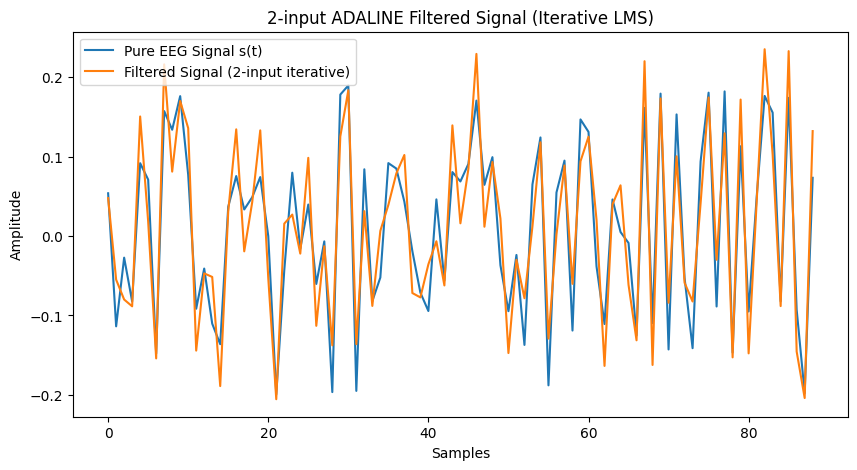

In [ ]:
# -------------------------------
# 3. Iterative LMS Solution for 2-input ADALINE (Neural Network 2)
# -------------------------------
# Use a segment of data (e.g., first 90 samples) for training
N = 90  # total number of samples used in this example
# Build the input matrix X for the 2-input filter:
# Each column is [v(k); v(k-1)]
N_iter = N - 1  # because we lose one sample for v(k-1)
X_2 = np.vstack((v[1:N], v[0:N-1]))  # shape: (2, N_iter)
T_2 = t[1:N]  # target signal corresponding to these samples

alpha = 0.001  # learning rate (tune as needed)
epochs = 10    # number of passes over the data

# Initialize weights for the iterative LMS
w_iter_2 = np.zeros(2)
for epoch in range(epochs):
    for k in range(N_iter):
        a_k = np.dot(w_iter_2, X_2[:, k])  # ADALINE output a(k)
        e_k = T_2[k] - a_k                  # error e(k)
        w_iter_2 = w_iter_2 + 2 * alpha * e_k * X_2[:, k]
print("Iterative LMS weights (2-input ADALINE):", w_iter_2)

# Compute the filtered output and the error signal
a_iter_2 = np.dot(w_iter_2, X_2)
e_signal_2 = T_2 - a_iter_2

plt.figure(figsize=(10, 5))
plt.plot(S[1:N], label='Pure EEG Signal s(t)')
plt.plot(e_signal_2, label='Filtered Signal (2-input iterative)')
plt.legend()
plt.title('2-input ADALINE Filtered Signal (Iterative LMS)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Second Order Filter Design: ADALINE Design based on Iterative Solution
- The optimal solution is obtained by minimizing least mean square (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$.

Iterative LMS weights (3-input, Third Order ADALINE): [ 0.00624437 -0.04598296  0.03973858]


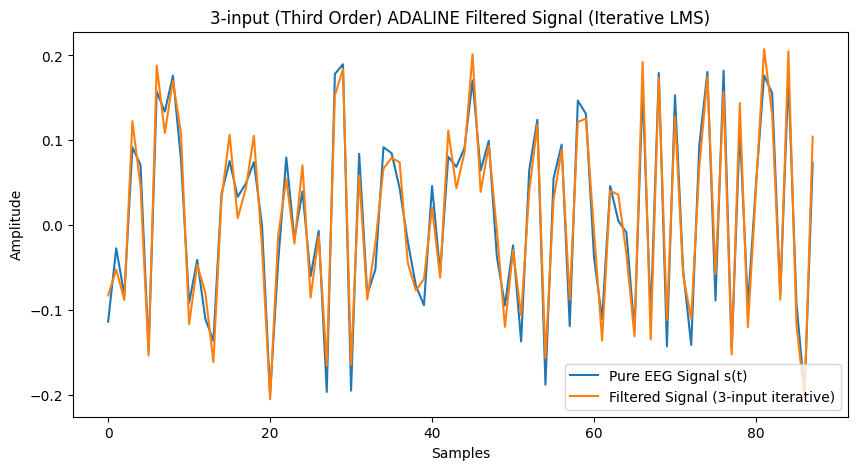

In [ ]:
# -------------------------------
# 4. Iterative LMS Solution for 3-input ADALINE (Third Order)
# -------------------------------
# For a third order ADALINE, we include an extra delayed input v(k-2)
N_iter3 = N - 2  # number of training samples (lose two samples now)
X_3 = np.vstack((v[2:N], v[1:N-1], v[0:N-2]))  # shape: (3, N_iter3)
T_3 = t[2:N]  # target signal adjusted accordingly

alpha3 = 0.001  # learning rate (can be tuned independently)
epochs3 = 10

w_iter_3 = np.zeros(3)
for epoch in range(epochs3):
    for k in range(N_iter3):
        a_k = np.dot(w_iter_3, X_3[:, k])
        e_k = T_3[k] - a_k
        w_iter_3 = w_iter_3 + 2 * alpha3 * e_k * X_3[:, k]
print("Iterative LMS weights (3-input, Third Order ADALINE):", w_iter_3)

# Compute filtered output for third order ADALINE
a_iter_3 = np.dot(w_iter_3, X_3)
e_signal_3 = T_3 - a_iter_3

plt.figure(figsize=(10, 5))
plt.plot(S[2:N], label='Pure EEG Signal s(t)')
plt.plot(e_signal_3, label='Filtered Signal (3-input iterative)')
plt.legend()
plt.title('3-input (Third Order) ADALINE Filtered Signal (Iterative LMS)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Filter Design: ADALINE Design based using KERAS
- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiltered signal $T(k)$ considered as target signal and the output of ADALINE network.
- KERAS allow to define optimization algorithms and paremetters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Keras ADALINE weights (2-input): [0.11726644 0.01563434]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


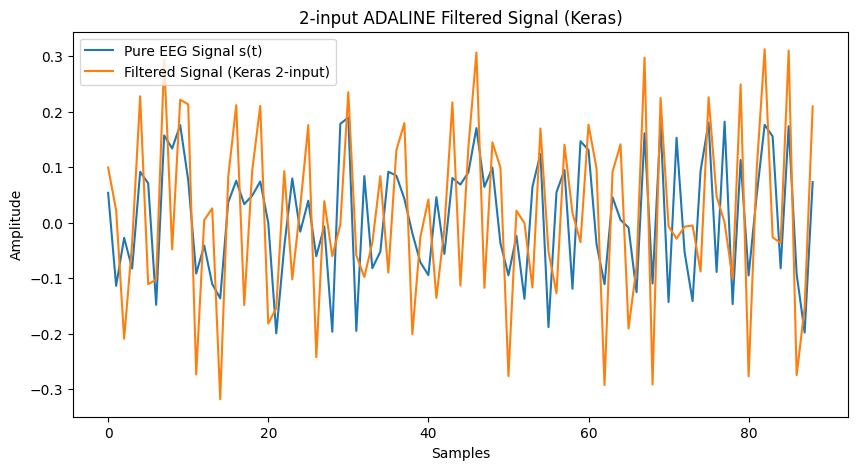

In [ ]:
# -------------------------------
# 5. Keras Implementation for 2-input ADALINE
# -------------------------------
# Prepare the data: each row is a sample with two features: [v(k), v(k-1)]
X_keras = X_2.T  # shape: (N_iter, 2)
Y_keras = T_2    # target signal

# Build a simple linear model with one neuron and no bias
model = models.Sequential()
model.add(layers.Dense(1, input_dim=2, use_bias=False))
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='mse')

# Train the model (adjust the number of epochs as needed)
history = model.fit(X_keras, Y_keras, epochs=50, verbose=0)

# Extract the learned weights
weights_keras = model.get_weights()[0].flatten()
print("Keras ADALINE weights (2-input):", weights_keras)

# Compute predictions using the Keras model
a_keras = model.predict(X_keras).flatten()
e_signal_keras = T_2 - a_keras

plt.figure(figsize=(10, 5))
plt.plot(S[1:N], label='Pure EEG Signal s(t)')
plt.plot(e_signal_keras, label='Filtered Signal (Keras 2-input)')
plt.legend()
plt.title('2-input ADALINE Filtered Signal (Keras)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

 # Simulate ADALINE
 - obtain the synaptic weights from network model via **model.get_weights()** and propagate the input signal to the ADALINE output **$a(t)$** using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$ or  $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$ corresponding to first or second order ADALINE flter.

# Simulate ADALINE
 - propagate the input signal using  KERAS command **model.predict(input_NN)** in order to obtain the ADALINE output **$a(t)$**

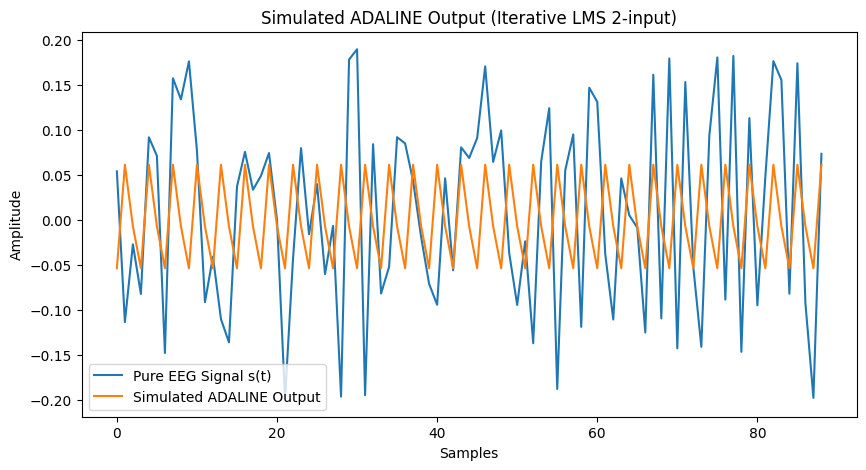

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


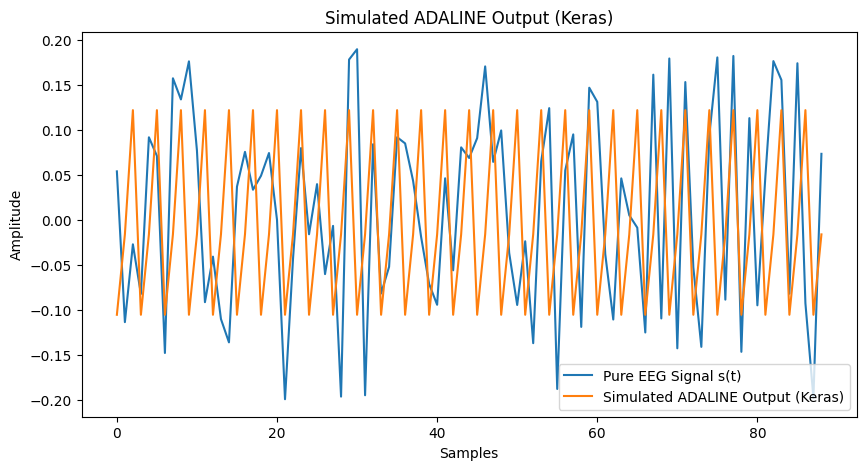

In [ ]:
# --- After iterative LMS for 2-input ADALINE ---
# Compute the simulated ADALINE output using the learned weights:
a_iter_2 = np.dot(w_iter_2, X_2)  # This simulates a(k)=w11*v(k)+w12*v(k-1)

# Plot the simulated output vs. the pure EEG signal:
plt.figure(figsize=(10, 5))
plt.plot(S[1:N], label='Pure EEG Signal s(t)')
plt.plot(a_iter_2, label='Simulated ADALINE Output')
plt.legend()
plt.title('Simulated ADALINE Output (Iterative LMS 2-input)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# --- Using Keras ---
# After training the Keras model, simulate the ADALINE output using model.predict():
a_keras = model.predict(X_keras).flatten()  # This uses the trained network to produce a(k)
plt.figure(figsize=(10, 5))
plt.plot(S[1:N], label='Pure EEG Signal s(t)')
plt.plot(a_keras, label='Simulated ADALINE Output (Keras)')
plt.legend()
plt.title('Simulated ADALINE Output (Keras)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()